# Определение токсичных комментариев

>[Определение токсичных комментариев](#scrollTo=7al-rwE8rwcZ)

>>>[Описание проекта](#scrollTo=T8xa10zKrwca)

>>>[Описание данных](#scrollTo=UMevSy5Hsi_N)

>>[Шаг 1. Подготовка](#scrollTo=rImTYcmDstMM)

>>>[1.1. Импорт библиотек](#scrollTo=c0nEh39RslyM)

>>>[1.2. Загрузка и предварительный осмотр данных](#scrollTo=39Eus7ewrwcb)

>>>[1.3. Очищение и лемматизация](#scrollTo=eWNM7i5Fs-I8)

>>>[1.4. Разделение на выборки](#scrollTo=vkmMmRsUrwcd)

>>>[Вывод по шагу 1](#scrollTo=YdNLfZzbrwcd)

>>[Шаг 2. Векторизация и обучение](#scrollTo=R7uPNPj7rwce)

>>>[2.1. Пайплайн для векторизации и обучения](#scrollTo=fLAAVdXru6DD)

>>>[2.2. Выбор лучшей модели](#scrollTo=36SatlupvHl8)

>>>[2.3. Проверка на тестовой выборке](#scrollTo=LcMbyckhvXib)

>>>[Вывод по шагу 2](#scrollTo=7ViWMuSExL9S)

>>[Шаг 3. Анализ ошибок](#scrollTo=7A6YunB8rwci)

>>>[Выводы по шагу 3](#scrollTo=LfN1nHssyETo)

>>[Итоговые выводы](#scrollTo=r8-iDciSrwci)



### Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности.

Построим модель со значением метрики качества *F1* не меньше 0.75 на тестовой выборке.


### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* содержит текст комментария, а *toxic* — целевой признак.



## Шаг 1. Подготовка

### 1.1. Импорт библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('omw-1.4')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (f1_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay)
from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV)

! pip install tqdm -q
from tqdm import tqdm
tqdm.pandas()

! pip install optuna -q
! pip install optuna-integration[sklearn] -q
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution

import warnings
from warnings import simplefilter

RANDOM_STATE = 42

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



### 1.2. Загрузка и предварительный осмотр данных

In [ ]:
toxic = pd.read_csv('/datasets/toxic_comments.csv', index_col = 0)

display(toxic.head())
print(toxic.info())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB
None


In [ ]:
print(toxic['text'].duplicated().sum())

0


In [ ]:
print(toxic['toxic'].value_counts())

0    143106
1     16186
Name: toxic, dtype: int64


Данные отображаются корректно, не содержат пропусков и дубликатов. Типы данных соответствуют ожиданиям. Тексты на английском языке.

В текстах встречаются символы разделения строки, знаки препинания, заглавные буквы. Это требует обработки.

Наблюдается сильный дисбаланс классов. Учтем это при разделении на выборки.

Необходимо будет произвести лемматизацию и векторизацию текстов на английском языке. Причем разбить данные на тренировочную и тестовую выборки нужно до этого.



### 1.3. Очищение и лемматизация
Создадим функцию `clean_lemmatize` для очистки и лемматизации текстов, применяя регулярные выражения.

In [ ]:
nlp = spacy.load('en_core_web_sm')
def clean_lemmatize(text):
    text = text.lower()
    text = nlp(' '.join(re.sub(r'[^a-zA-z]', ' ', text).split()))
    text = ' '.join([word.lemma_ for word in text])
    return text

In [ ]:
toxic['lemm_spacy_text'] = toxic['text'].progress_apply(clean_lemmatize)
display(toxic['lemm_spacy_text'].head(10))

100%|██████████| 159292/159292 [34:56<00:00, 75.99it/s] 


0    explanation why the edit make under my usernam...
1    d aww he match this background colour I m seem...
2    hey man I m really not try to edit war it s ju...
3    more I can t make any real suggestion on impro...
4    you sir be my hero any chance you remember wha...
5    congratulation from I as well use the tool wel...
6         cocksucker before you piss around on my work
7    your vandalism to the matt shirvington article...
8    sorry if the word nonsense be offensive to you...
9    alignment on this subject and which be contrar...
Name: lemm_spacy_text, dtype: object

Тексты очищены и лемматизированы.

Перед обучением еще необходимо их векторизировать, но для избежания утечки данных, векторизацию тренировочной и тестовой выборок нужно проводить отдельно.

### 1.4. Разделение на выборки

При разделении на выборки применим стратификацию по целевому признаку, чтобы избежать ошибок, вызванных дисбалансом классов.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    toxic['lemm_spacy_text'],
    toxic['toxic'],
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=toxic['toxic'])

print('Размер тренировочной выборки:', X_train.shape[0])
print('Размер тестовой выборки:', X_test.shape[0])

Размер тренировочной выборки: 119469
Размер тестовой выборки: 39823


### Вывод по шагу 1
Данные загружены, отображаются корректно, не содержат пропусков и дубликатов. Типы данных соответствуют ожиданиям. Тексты на английском языке.

Очистили тексты от лишних символов, привели все к нижнему регистру, лемматизировали.

Разделили данные на тренировочную и тестовую выборки с учетом дисбаланса классов.

## Шаг 2. Векторизация и обучение



### 2.1. Пайплайн для векторизации и обучения
Построим пайплайн для векторизации текстов методом `TF-IDF` и обучения модели логистической регрессии и дерева решений.

In [ ]:
stop_words = nltk_stopwords.words('english')
pipe = Pipeline(
    [('vec', TfidfVectorizer(stop_words=stop_words)),
     ('models', LogisticRegression())]
)
params = [
    {
        'models': [LogisticRegression(class_weight='balanced')],
        'models__C': [3, 5, 10]
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__min_samples_leaf': range(2, 5)
    }
]

### 2.2. Выбор лучшей модели

Выберем лучшую модель и ее гиперпараметры при помощи `RandomizedSearchCV`.

In [ ]:
search = RandomizedSearchCV(
        pipe,
        params,
        scoring='f1',
        n_iter=15,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    search.fit(X_train, y_train)
best_estimator = search.best_estimator_

print('Лучшая модель и ее параметры:\n', best_estimator)
print(search.best_params_)
print()
print ('Метрика F1 лучшей модели на кросс-валидации:',
       search.best_score_)

Лучшая модель и ее параметры:
 Pipeline(steps=[('vec',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('models', LogisticRegression(C=3, class_weight='balanced'))])
{'models__C': 3, 'models': LogisticRegression(C=3, class_weight='balanced')}

Метрика F1 лучшей модели на кросс-валидации: 0.7630928260693313


Лучшей оказалась модель логистической регрессии с параметром *С*=3. Ее метрика *F1* на кросс-валидации больше 0.75, что отвечает требованиям. Проверим модель на тестовой выборке.


### 2.3. Проверка на тестовой выборке

In [ ]:
predict_test = best_estimator.predict(X_test)
print('Метрика F1 на тестовой выборке:', f1_score(y_test, predict_test))

Метрика F1 на тестовой выборке: 0.765556676757484


На тестовой выборке модель также показала удовлетворительный результат. Можно остановиться на модели логистической регрессии с параметром *C*=3.

### Вывод по шагу 2

Векторизировали тексты методом `TF-IDF` и обучили модели в пайплайне.

Сравнили логистическую регрессию и дерево решений с перебором гиперпараметров.

Выбрали лучшую модель методом `RandomizedSearchCV`. Ею оказалась модель логистической регрессии с параметром *С=3*. Ее метрика *F1* на кросс-валидации больше 0.75, что отвечает требованиям.

На тестовой выборке выбранная модель также показала удовлетворительный результат *F1* больше 0.76.

## Шаг 3. Анализ ошибок
Построим матрицу ошибок модели.

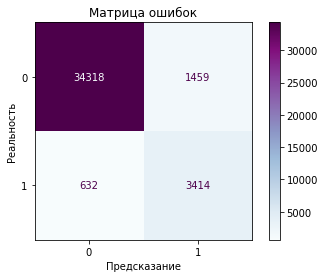

In [ ]:
cm = confusion_matrix(y_test, predict_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='BuPu')
plt.title('Матрица ошибок')
plt.xlabel('Предсказание')
plt.ylabel('Реальность')
plt.show()

### Выводы по шагу 3

Модель чаще допускает ошибки первого рода (ложноположительное предсказание), чем ошибки второго рода (ложноотрицательное предсказание). Однако с учетом сравнительно малого числа объектов класса 1, получаем, что модель хуже их распознает, чем объекты класса 0.
Возможно, при необходимости эту проблему можно было бы решить методами сэмплирования.

## Итоговые выводы

1. Полученные данные не содержали пропусков и дубликатов. Язык текстов - английский.

2. Очистили тексты от лишних символов, привели все к нижнему регистру, лемматизировали. Разделили данные на тренировочную и тестовую выборки с учетом дисбаланса классов.  
3. Построили пайплайн для векторизации текстов и обучения моделей. Перебрали гиперпараметры для логистической регрессии и дерева решений, получили на кросс-валидации результаты, превышающие необходимый порог качества.
4. Результат на тестовой выборке также удовлетворительный. Остановились на модели логистической регрессии с параметром *C*=3.
5. Построили матрицу ошибок модели. Определили, что в абсолютном выражении модель чаще допускает ошибки первого рода, чем второго рода; но хуже распознает объекты класса 1, чем объекты класса 0. Возможно, при необходимости эту проблему можно было бы решить методами сэмплирования.